In [36]:
# Getting the necessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
from sklearn.preprocessing import StandardScaler
from summarytools import dfSummary
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Data Source:
https://ec.europa.eu/eurostat/databrowser/view/avia_paocc/default/table?lang=en&category=avia.avia_pa.avia_pao

# Towards Data Science Article Link for Time Series: 
https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6/

## Meaning of some columns
### The tra_meas column categorizes the passenger data as follows:

#### tra_meas Values
* Passengers carried: Total number of passengers transported by air, regardless of whether they are arriving or departing. This is the total passenger count for flights associated with Germany (e.g., flights to/from/within Germany). In your dataset, there are 277 entries with this measurement.

* Passengers carried (arrivals): Number of passengers who arrived in Germany on flights. This counts passengers disembarking in Germany (e.g., at German airports like Frankfurt or Munich). There are 277 entries for this.

* Passengers carried (departures): Number of passengers who departed from Germany on flights. This counts passengers boarding flights leaving Germany. There are 277 entries for this.

* Passengers on board: Total number of passengers on board flights associated with Germany, regardless of arrival or departure. This might overlap with "Passengers carried" but could reflect a slightly different reporting metric (e.g., passengers on flights operated by German carriers). There are 277 entries for this.

* Passengers on board (arrivals): Number of passengers on board flights arriving in Germany. This is similar to "Passengers carried (arrivals)" but might reflect passengers on the flight rather than those who disembark (e.g., including transit passengers). There are 277 entries for this.

* Passengers on board (departures): Number of passengers on board flights departing from Germany. Similar to "Passengers carried (departures)" but might include transit passengers. There are 277 entries for this.

* unit
* tra_cov
* geo: Location of where the passengers are landing and leaving from
* TIME_PERIOD: Which year and month we are referring to with for Germany starting from 2002-January-01 to 2025-May
* Total_Passengers: # of Passengers boarding and departing in and out of Germany
* EMA_0.3: Estimated Moving Average with a specific alpha value (0.3)
* EMA_0.8: Estimated Moving Average with a specific alpha value (0.3)
* EMA_0.7: Estimated Moving Average with a specific alpha value (0.3) 
* EMA_0.75: Estimated Moving Average with a specific alpha value (0.3)
* Rolling_window2: Another moving average with rolling windows 2

In [37]:
# ob_cleaned.columns

In [38]:
air = pd.read_csv('dataset/airpassenger.csv')

In [39]:
air.head()

,DATAFLOW,LAST UPDATE,freq,unit,tra_meas,tra_cov,schedule,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-01,935901,NaN,NaN
1,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-02,966771,NaN,NaN
2,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-03,1184268,NaN,NaN
3,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-04,1143982,NaN,NaN
4,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-05,1326116,NaN,NaN


In [40]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54555 entries, 0 to 54554
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     54555 non-null  object 
 1   LAST UPDATE  54555 non-null  object 
 2   freq         54555 non-null  object 
 3   unit         54555 non-null  object 
 4   tra_meas     54555 non-null  object 
 5   tra_cov      54555 non-null  object 
 6   schedule     54555 non-null  object 
 7   geo          54555 non-null  object 
 8   TIME_PERIOD  54555 non-null  object 
 9   OBS_VALUE    54555 non-null  int64  
 10  OBS_FLAG     0 non-null      float64
 11  CONF_STATUS  0 non-null      float64
dtypes: float64(2), int64(1), object(9)
memory usage: 5.0+ MB


In [41]:
air['TIME_PERIOD'] = pd.to_datetime(air['TIME_PERIOD'])

In [42]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54555 entries, 0 to 54554
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATAFLOW     54555 non-null  object        
 1   LAST UPDATE  54555 non-null  object        
 2   freq         54555 non-null  object        
 3   unit         54555 non-null  object        
 4   tra_meas     54555 non-null  object        
 5   tra_cov      54555 non-null  object        
 6   schedule     54555 non-null  object        
 7   geo          54555 non-null  object        
 8   TIME_PERIOD  54555 non-null  datetime64[ns]
 9   OBS_VALUE    54555 non-null  int64         
 10  OBS_FLAG     0 non-null      float64       
 11  CONF_STATUS  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 5.0+ MB


In [43]:
air = air.set_index(air['TIME_PERIOD'])

In [44]:
air = air.sort_index()

In [45]:
air_germany = air[air['geo'] == 'Germany']

In [46]:
air_germany.head(10)

,DATAFLOW,LAST UPDATE,freq,unit,tra_meas,tra_cov,schedule,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
TIME_PERIOD,,,,,,,,,,,,
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (arrival),Total transport,Total,Germany,2002-01-01,4287851,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Germany,2002-01-01,7044282,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried,Total transport,Total,Germany,2002-01-01,6875419,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board (departures),Total transport,Total,Germany,2002-01-01,4189696,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (departures),Total transport,Total,Germany,2002-01-01,4086737,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board (arrivals),Total transport,Total,Germany,2002-01-01,4423072,NaN,NaN
2002-02-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (arrival),Total transport,Total,Germany,2002-02-01,4281142,NaN,NaN
2002-02-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board (arrivals),Total transport,Total,Germany,2002-02-01,4408669,NaN,NaN
2002-02-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (departures),Total transport,Total,Germany,2002-02-01,4489250,NaN,NaN


In [47]:
ag_cleaned = air_germany.drop(labels=['DATAFLOW', 'freq', 'schedule',
                         'OBS_FLAG',
                         'CONF_STATUS',
                         'LAST UPDATE'],
                 axis = 1)

In [48]:
ag_cleaned.rename({'OBS_VALUE': 'Total_Passengers'}, axis  = 1, inplace=True)

In [49]:
ag_cleaned['tra_meas'].value_counts()

tra_meas
Passengers carried (arrival)        277
Passengers on board                 277
Passengers carried                  277
Passengers on board (departures)    277
Passengers carried (departures)     277
Passengers on board (arrivals)      277
Name: count, dtype: int64

In [50]:
ob_cleaned = ag_cleaned[ag_cleaned['tra_meas'] == 'Passengers on board']

In [51]:
skim(ob_cleaned)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 277    │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 6      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name ┃ NA ┃ NA % ┃ mean     ┃ sd      ┃ p0     ┃ p25      ┃ p50      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ Total_Passe │  0 │    0 │ 13780000 │ 4530000 │ 274300 │ 11230000 │ 13820000 │ 16900000 │ 22910000 │ ▁▁▆▇▇▃ │  │
│ │ ngers       │    │      │          │         │        │          │          │          │          │        │  │
│ └─────────────┴────┴──────┴──────────┴─────────┴────────┴──────────┴──────────┴──────────┴──────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ TIME_PERIOD            │      0 │         0 │     2002-01-01      │     2025-01-01      │ MS               │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ unit                      │       0 │          0 │                            1 │                      277 │  │
│ │ tra_meas                  │       0 │          0 │                            3 │                      831 │  │
│ │ tra_cov                   │       0 │          0 │                            2 │                      554 │  │
│ │ geo                       │       0 │          0 │                            1 │                      277 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [52]:
dfSummary(ob_cleaned)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,unit[object],1. Passenger,277 (100.0%),,0(0.0%)
2,tra_meas[object],1. Passengers on board,277 (100.0%),,0(0.0%)
3,tra_cov[object],1. Total transport,277 (100.0%),,0(0.0%)
4,geo[object],1. Germany,277 (100.0%),,0(0.0%)
5,TIME_PERIOD[datetime64[ns]],"Min: 2002-01-01Max: 2025-01-01Duration: 8,401 days",277 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACQklEQVR4nO3YvY7aQBSG4TPAggHLFmJjOpqUkVK49EXkYnMJQeIKKNJsRYdkIVs4izCO02SlFOHHK+3ndfI+rRnP0fAOBa6uawMUem0PgP8HsUFmcO2hc25sZsNXvLdnZj9fse5U1/Vz00UtzGmmn7UrZ3NxzouxOefG8/n8SxAEsyY7VVX1UBTFR9/3n3q9XtlkbZ7ne+fc1yaH2sac6lnV+73Vd3jtl20YBMEsSZLnMAyP92623W5nm83mQxzH3xeLxf7edVmWeavVKkrT9NE5l9+7zswC3/ejJElyxZxtzNqVs8myzFuv17M0TYdm1ig2MzMLw/AYRdGPezfc7/djM7PpdNpoXVEUD2VZfl4ul/1+v3/3wZRl6VVV9Wk0Gn1TzNnGrF06GzMbX3pwMzaV0+k08DxvEsfxsclt+n0LJ+fzuf+W8/1JPWuXzuaadxPbi6a36eUWtkE9a5fO5m/46wMyxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDzODWB7Is85q88HA4eGZmRVF4u91u8q+t69Ks6nW3WvkFbBFstpFl4sYAAAAASUVORK5CYII="">",0(0.0%)
6,Total_Passengers[int64],Mean (sd) : 13777159.8 (4530394.5)min < med < max:274314.0 < 13820925.0 < 22907255.0IQR (CV) : 5669250.0 (3.0),277 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACv0lEQVR4nO3dT27aQBSA8TclgPkjI4QEOy5QqQuWPkQP2yNkkRNwA3ZICBnhxsIYd5WKtGmCZ+wwb/r99gYvPjn2G+IxVVUJ4Lsv9z4B4BYP9z6BEBljBiLSszz8VFXVc5PnEwJCbZgxZjCbzb7HcTy1Of5wOOyNMT+I9TVCbV4vjuNpkiTPk8kkr3NgmqbR09PTdLfb9USEUK8Qaksmk0k+n89/Whw6aPxkAsDDFFQgVKhAqFCBe1TPlGXZFZHYGGP7EUGOtwjVI1mWdYui+LZcLjudTqfWxOBFqOMtQvXI6XR6iKJouFqt8sVisa97fMjjLUL9B4fVpfhyuXRdvns0GtmOtkQCHW8R6htcVpeKoojKsvya5/mjiNjGhj8Q6tusV5c2m810vV4Pz+dzp62T+x8R6jtsVpf2+/1d//Q6Tg28nRgQakBcpwY+TwwINSAuUwPfJwaEGiCHqYG3EwOWUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVOBnfvjN53cKECpExP93ChAqRMT/dwoQKl7x9Z0CPExBBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQI9tdTDruaiDSwswmaFWSoLruaiLCziY+CDFUcdjURYWcTH4UaqojY7Woicv+dTfC3oEPF52pz6yBCRSPa3jqIUNGItrcOIlQ0qq2tgz4M1XEe6e2WhdDl3VBd55E+b1kIXT66olrPI33fshC63HSPajuPFI+3LIQuXj9MOdwfs1YfGG9Ddbk/Zq0+PK2G6rhSEY/H43mSJIe698es1YentVBdVyperor9fv+x7v0xa/XhaS1U19cYclXEtdbvUW1XKrgq4hr/igIVbrqipmka1f3g4/EYiYhkWRZtt9vhZx6v9bu1nrfr8bf09QvZ+7TZm/YH4AAAAABJRU5ErkJggg=="">",0(0.0%)


In [53]:
ag_cleaned.head(6)

,unit,tra_meas,tra_cov,geo,TIME_PERIOD,Total_Passengers
TIME_PERIOD,,,,,,
2002-01-01,Passenger,Passengers carried (arrival),Total transport,Germany,2002-01-01,4287851
2002-01-01,Passenger,Passengers on board,Total transport,Germany,2002-01-01,7044282
2002-01-01,Passenger,Passengers carried,Total transport,Germany,2002-01-01,6875419
2002-01-01,Passenger,Passengers on board (departures),Total transport,Germany,2002-01-01,4189696
2002-01-01,Passenger,Passengers carried (departures),Total transport,Germany,2002-01-01,4086737
2002-01-01,Passenger,Passengers on board (arrivals),Total transport,Germany,2002-01-01,4423072


In [54]:
index = ob_cleaned['Total_Passengers'].loc['2002' : ' 2024'].index
data = ob_cleaned['Total_Passengers'].loc['2002' : '2024']

[Text(0.5, 1.0, 'Time Series of Travel in Germany (2002 - 2024)'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Number of passengers')]

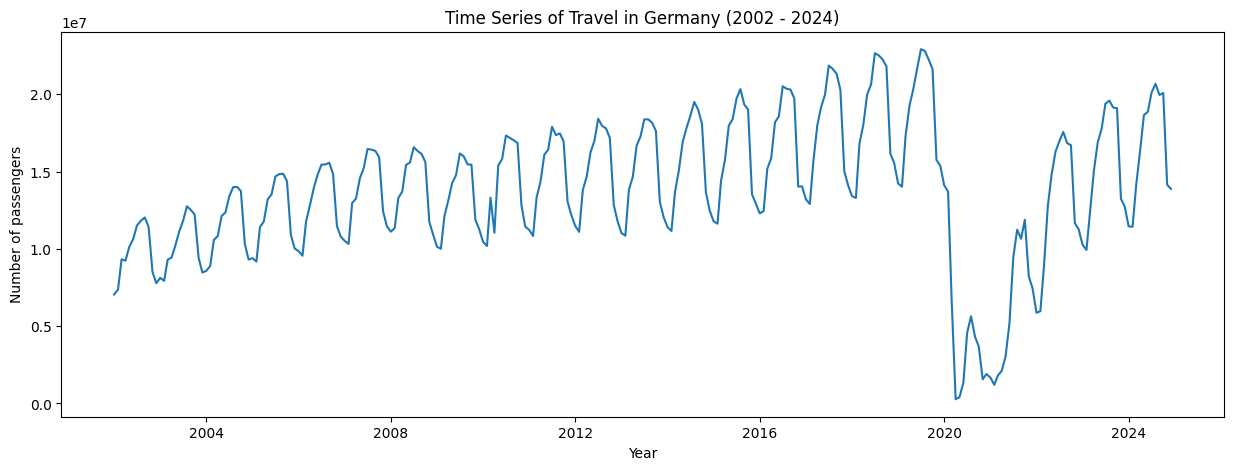

In [55]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(index, data)
ax.set(title = 'Time Series of Travel in Germany (2002 - 2024)', xlabel='Year', ylabel = 'Number of passengers')
# ag_cleaned.loc['2022': '2024']['Total_Passengers'].plot(figsize=(15, 5), xlim=['2022', '2024'])

In [56]:
## EWMA - Exponential Weighted Moving Average. (alpha is a smoothing factor)
ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_13156\306907157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()


In [57]:
ob_cleaned['EMA_0.8'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.8, adjust = False).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_13156\232709973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.8'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.8, adjust = False).mean()


In [58]:
ob_cleaned['EMA_0.7'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.7, adjust = False).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_13156\399242477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.7'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.7, adjust = False).mean()


<Axes: xlabel='TIME_PERIOD'>

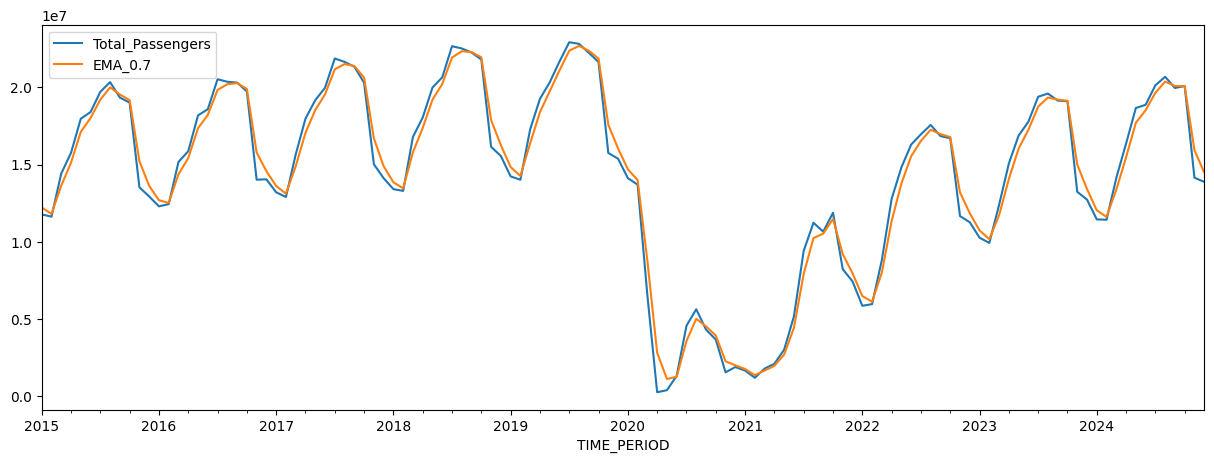

In [59]:
ob_cleaned.loc['2015' :' 2024'][['Total_Passengers', 'EMA_0.7']].plot(figsize=(15, 5))

In [60]:
ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()
ob_cleaned['EMA_0.75'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.75, adjust = False).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_13156\2579157987.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()
C:\Users\hassa\AppData\Local\Temp\ipykernel_13156\2579157987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.75'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.75, adjust = False).mean()


<Axes: xlabel='TIME_PERIOD'>

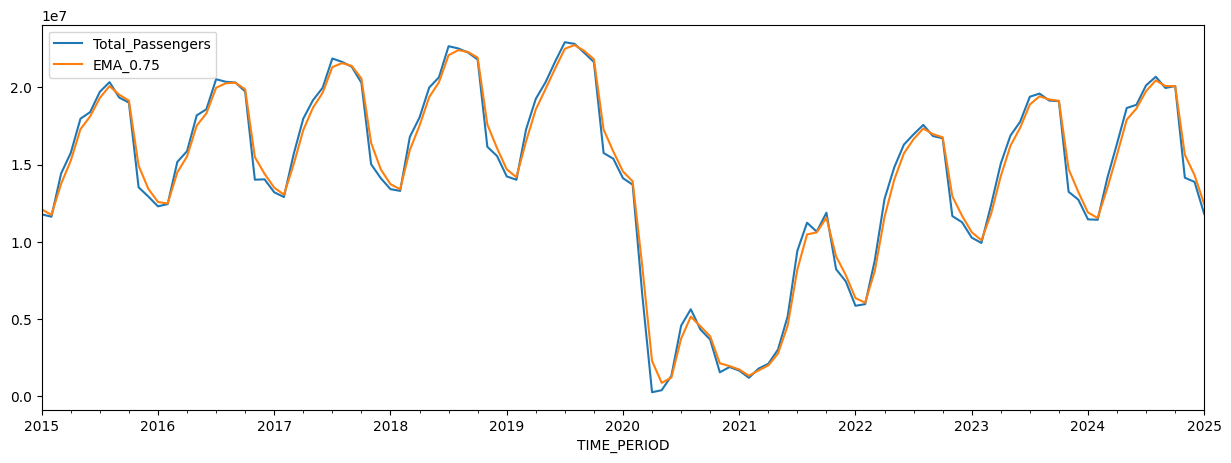

In [61]:
## EWMA - Exponential Weighted Moving Average
ob_cleaned.loc['2015': '2025'][['Total_Passengers', 'EMA_0.75']].plot(figsize=(15, 5))

In [62]:
ob_cleaned['Rolling_window2'] = ob_cleaned['Total_Passengers'].rolling(window=2).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_13156\2308598096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['Rolling_window2'] = ob_cleaned['Total_Passengers'].rolling(window=2).mean()


<Axes: xlabel='TIME_PERIOD'>

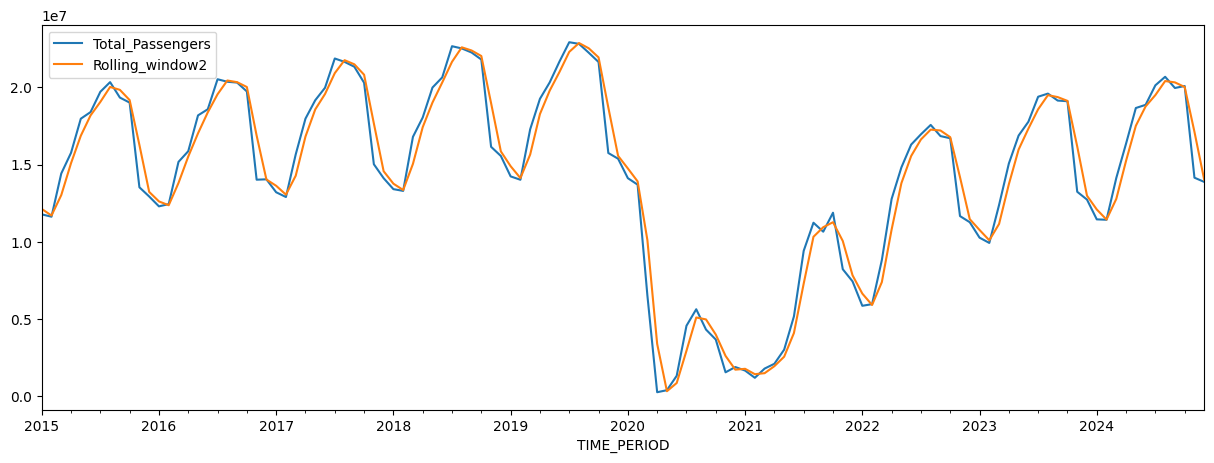

In [63]:
## EWMA - Exponential Weighted Moving Average
ob_cleaned.loc['2015': '2024'][['Total_Passengers', 'Rolling_window2']].plot(figsize=(15, 5))

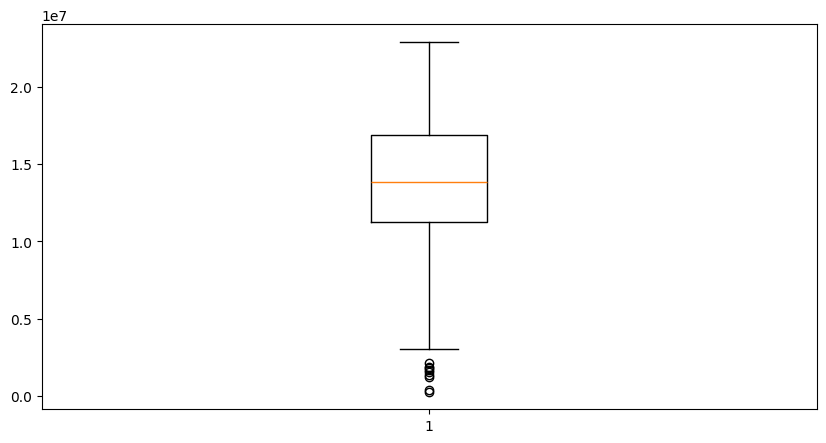

In [64]:
fig, ax = plt.subplots(figsize = (10,5 ))
ax.boxplot(x = 'Total_Passengers', data=ob_cleaned)
plt.show()

In [65]:
result = adfuller(ob_cleaned['Total_Passengers'])

z = (x - u) / s

In [ ]:
# H0 = The graph is not stationary
# H1 = The graph is stationary

def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic', 'p-value', '#Lags used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

    if result[1] <= 0.05:
        print('We reject the null. The graph is stationary')
    else:
        print('We accept the null hypothesis, the graph is indeed not stationary')    

In [67]:
adfuller_test(ob_cleaned['Total_Passengers'])

ADF Test Statistic : -3.659785129833758
p-value : 0.004715716764461448
#Lags used : 13
We reject the null. The graph is stationary


In [68]:
ob_cleaned['Total_Passengers_First_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(1)

C:\Users\hassa\AppData\Local\Temp\ipykernel_13156\3573525325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['Total_Passengers_First_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(1)


<Axes: xlabel='TIME_PERIOD'>

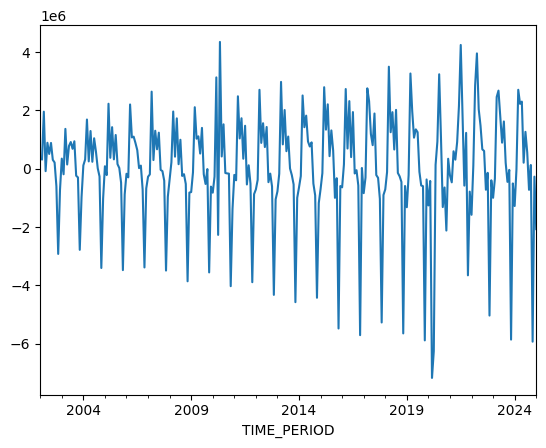

In [83]:
ob_cleaned['Total_Passengers_First_Difference'].plot()

In [69]:
ob_cleaned['Total_Passengers_Twelve_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(12)

C:\Users\hassa\AppData\Local\Temp\ipykernel_13156\939315197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['Total_Passengers_Twelve_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(12)


In [70]:
ob_cleaned[['Total_Passengers', 'Total_Passengers_First_Difference', 'Total_Passengers_Twelve_Difference']]

,Total_Passengers,Total_Passengers_First_Difference,Total_Passengers_Twelve_Difference
TIME_PERIOD,,,
2002-01-01,7044282,NaN,NaN
2002-02-01,7365242,320960.0,NaN
2002-03-01,9319495,1954253.0,NaN
2002-04-01,9235463,-84032.0,NaN
2002-05-01,10124069,888606.0,NaN
...,...,...,...
2024-09-01,19947957,-723872.0,813740.0
2024-10-01,20074786,126829.0,981930.0
2024-11-01,14147115,-5927671.0,910590.0


In [71]:
adfuller_test(ob_cleaned['Total_Passengers_First_Difference'].dropna())

ADF Test Statistic : -4.076495182962014
p-value : 0.0010588904145885337
#Lags used : 15
We reject the null. The graph is stationary


In [72]:
adfuller_test(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

ADF Test Statistic : -3.9757555991194717
p-value : 0.0015429203708297356
#Lags used : 13
We reject the null. The graph is stationary


<Axes: xlabel='TIME_PERIOD'>

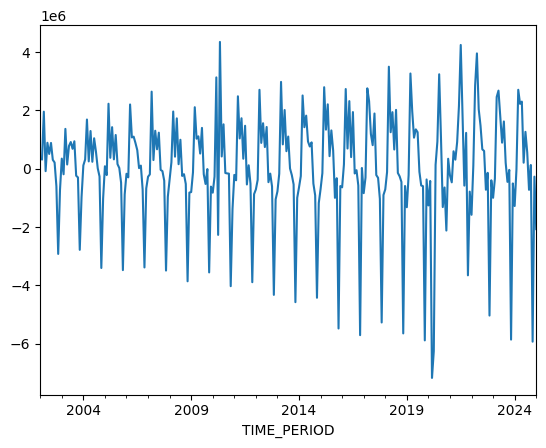

In [84]:
ob_cleaned['Total_Passengers_First_Difference'].plot()

<Axes: xlabel='TIME_PERIOD'>

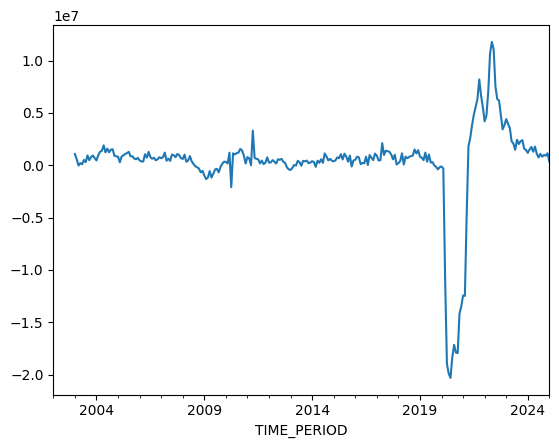

In [74]:
ob_cleaned['Total_Passengers_Twelve_Difference'].plot()

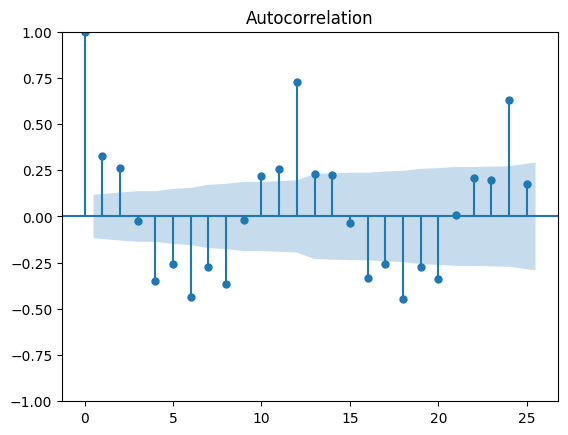

In [75]:
acf = plot_acf(ob_cleaned['Total_Passengers_First_Difference'].dropna())

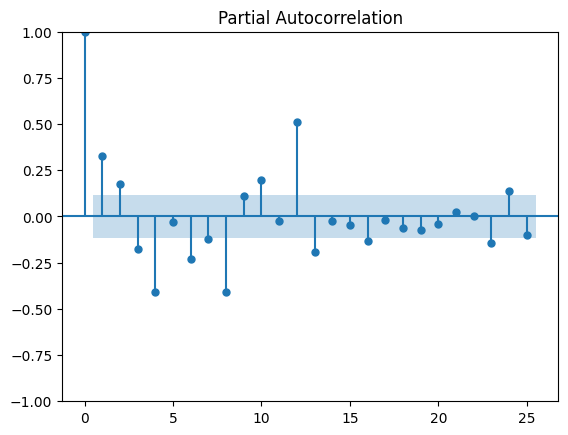

In [76]:
pacf = plot_pacf(ob_cleaned['Total_Passengers_First_Difference'].dropna())
#p = 25
#p = 13

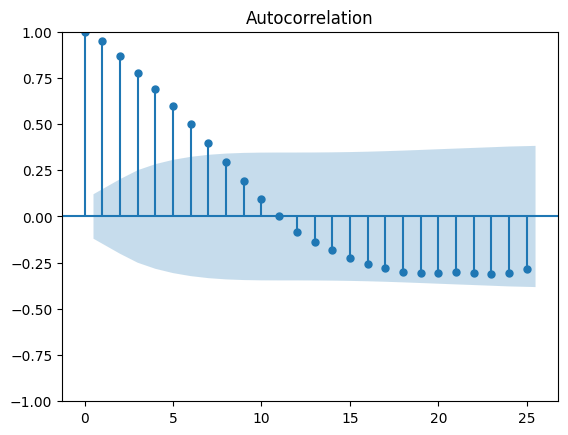

In [77]:
acf12 = plot_acf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

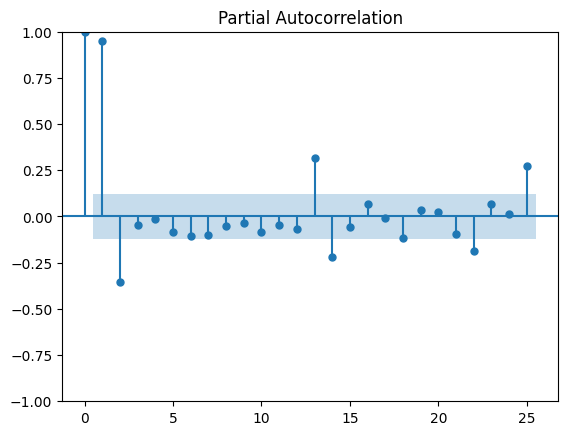

In [78]:
pacf12 = plot_pacf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

In [79]:
ob_cleaned['TIME_PERIOD'].max()

Timestamp('2025-01-01 00:00:00')

In [80]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2022, 12, 1)
test_dataset_end = datetime(2025, 1, 1)

In [81]:
train_data = ob_cleaned[:train_dataset_end]
test_data = ob_cleaned[train_dataset_end + timedelta(days = 1): test_dataset_end]

In [85]:
# model_ARIMA = ARIMA(train_data['Total_Passengers'], order = ())